# Spec_Phot_demo

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

""" parametric_mock_specphot.py -  Parametric Spectrum and Photometry fit
This is a parameter file with build_* methods for fitting spectra and photometry
with a single composite stellar population (tau-model.) We optionally include
spectrum or photometry, and can remove the spectral continuum shape by
optimizing out a polynomial at each model call, if use_continuum is False
"""

import time, sys
from copy import deepcopy
import numpy as np
from sedpy.observate import load_filters

from prospect import prospect_args
from prospect.fitting import fit_model
from prospect.io import write_results as writer

from prospect.sources.constants import cosmo

try:
    from exspect.utils import build_mock
    from exspect.utils import set_sdss_lsf, load_sdss
    from exspect.utils import fit_continuum, eline_mask
except(ImportError):
    pass

In [2]:
# Here we are going to put together some filter names
# All these filters are available in sedpy.  If you want to use other filters,
# add their transmission profiles to sedpy/sedpy/data/filters/ with appropriate
# names (and format)
galex = ['galex_FUV', 'galex_NUV']
sdss = ['sdss_{0}0'.format(b) for b in "griz"]
twomass = ['twomass_{}'.format(b) for b in ['J', 'H', 'Ks']]
bessell = ['bessell_{}'.format(b) for b in "UBVRI"]


# - Parser with default arguments -
parser = prospect_args.get_parser(["optimize", "dynesty"])
# Initial parameters
parser.add_argument('--zred', type=float, default=0.0,
                    help="Redshift for the model.")
parser.add_argument('--zred_disp', type=float, default=1e-3,
                    help="Redshift for the model (and mock).")
# Fitted Model specification
parser.add_argument('--add_neb', action="store_true",
                    help="If set, add nebular emission in the model (and mock).")
parser.add_argument('--add_realism', action="store_true",
                    help="If set, Add realistic instrumental dispersion.")
parser.add_argument('--continuum_order', type=int, default=0,
                    help="If > 0, optimize out the continuum shape.")
parser.add_argument('--outlier_model', action="store_true",
                    help="If set, add an outlier model for spectroscopy")
parser.add_argument('--jitter_model', action="store_true",
                    help="If set, fit for spectroscopic noise inflation term")
# Data construction
parser.add_argument('--ggc_data', type=str, default="data/ggc.h5",
                    help="Full path of GGC data HDF5 file")
parser.add_argument('--ggc_id', type=str, default="NGC104",
                    help="Name of the GGC object.")
parser.add_argument('--ggc_index', type=int, default=-1,
                    help="Index of the GGC object. Overrides ggc_id if >0")
parser.add_argument('--wave_lo', type=float, default=3800.,
                    help="Minimum wavelength to fit")
parser.add_argument('--wave_hi', type=float, default=6250.,
                    help="Maximum wavelength to fit")
parser.add_argument('--snr_phot', type=float, default=20,
                    help="S/N ratio for the photometry.")
parser.add_argument('--mask_elines', action="store_true",
                    help="If set, mask windows around bright emission lines")


_StoreTrueAction(option_strings=['--mask_elines'], dest='mask_elines', nargs=0, const=True, default=False, type=None, choices=None, help='If set, mask windows around bright emission lines', metavar=None)

In [3]:
# --------------
# MODEL SETUP
# --------------


def build_model(continuum_order=0, add_neb=False, zred=0., zred_disp=1e-3,
                jitter_model=False, outlier_model=False, **kwargs):
    """Instantiate and return a ProspectorParams model subclass.
    """
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors, sedmodel

    # --- Basic SSP at fixed distance (10 kpc) ---
    model_params = TemplateLibrary["ssp"]
    model_params["lumdist"] = dict(N=1, isfree=False, init=0.01)
    model_params["tage"]["init"] = 10.0
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e3, maxi=1e7)
    model_params["mass"]["init"] = 1e5

    # --- Complexify dust attenuation ---
    # Cardelli
    model_params["dust_type"]["init"] = 1
    # Slope of the attenuation curve, expressed as R_v
    model_params["mwr"] = dict(N=1, isfree=False, init=3.1)

    # --- Add smoothing parameters ---
    model_params.update(TemplateLibrary["spectral_smoothing"])
    model_params["sigma_smooth"]["prior"] = priors.TopHat(mini=0, maxi=50)
    model_params["sigma_smooth"]["init"] = 10.0
    # --- Add spectral fitting parameters ---
    if continuum_order > 0:
        model_params.update(TemplateLibrary["optimize_speccal"])
        model_params["polyorder"]["init"] = continuum_order

    # redshift
    model_params['zred']["isfree"] = True
    model_params['zred']["init"] = zred
    model_params['zred']['prior'] = priors.Normal(mean=zred, sigma=zred_disp)

    # Alter parameter values based on keyword arguments
    for p in list(model_params.keys()):
        if (p in kwargs):
            model_params[p]["init"] = kwargs[p]

    # Alter some priors?
    model_params["dust2"]["prior"].params["maxi"] = 2.5
    model_params["logzsol"]["prior"] = priors.TopHat(mini=-2, maxi=0.2)
    model_params["tage"]["prior"] = priors.TopHat(mini=1, maxi=13.8)

    if jitter_model:
        #pr = priors.LogNormal(mode=np.log(1.0), sigma=np.log(10))
        pr = priors.ClippedNormal(mean=3, sigma=10, mini=0, maxi=100)
        jitter = dict(N=1, init=1, isfree=True, prior=pr)
        model_params["spec_jitter"] = jitter

    if outlier_model:
        # just use the defaults
        model_params.update(TemplateLibrary["outlier_model"])

    if continuum_order > 0:
        return sedmodel.PolySpecModel(model_params)
    else:
        return sedmodel.SpecModel(model_params)


In [4]:
# --------------
# OBS
# --------------


def build_obs(ggc_data="data/ggc/ggc.h5", ggc_id="NGC104", ggc_index=-1,
              snr_spec=0, wave_lo=3800, wave_hi=7200., mask_elines=False,
              snr_phot=20., filterset=bessell, norm_band="bessell_V",
              continuum_optimize=False, **kwargs):
    """Load a ggc dataset

    :param wave_lo:
        The (restframe) minimum wavelength of the spectrum.

    :param wave_hi:
        The (restframe) maximum wavelength of the spectrum.

    :param filterset:
        A list of `sedpy` filter names.  Mock photometry will be generated
        for these filters.

    :param snr_phot:
        The S/N of the phock photometry.  This can also be a vector of same
        lngth as the number of filters, for heteroscedastic noise.

     :returns obs:
        Dictionary of observational data.
    """
    import h5py
    from prospect.utils.obsutils import fix_obs
    with h5py.File(ggc_data, "r") as hfile:
        if ggc_index >= 0:
            ggc_id = list(hfile.keys())[ggc_index]
        group = hfile[ggc_id]
        info = group["info"][:]
        spec = group["spec"][:]

    print(ggc_id)

    # --- Now fill the obs dictionary ----
    obs = dict(cluster=ggc_id, distance_kpc=info["dist"], ebv=info["ebv"], vrad=info["vrad"],
               wavelength=spec["wavelength"], spectrum=spec["spectrum"], unc=spec["unc"],
               sky=spec["sky"])
    obs['mask'] = ((obs["wavelength"] > 0) & (obs["unc"] > 0) &
                   (obs["wavelength"] > wave_lo) & (obs["wavelength"] < wave_hi))

    bands = [f.split('_')[-1] for f in filterset]
    mags = np.squeeze(np.array([info[b] for b in bands]))
    # shift to 10 kpc
    dm = 5.0 * np.log10(obs["distance_kpc"] / 10.0)
    obs["filters"] = load_filters(filterset)
    obs["maggies"] = np.squeeze(10**(-0.4 * (mags - dm)))
    # The photometry does not come with errors...
    obs["maggies_unc"] = obs["maggies"] / snr_phot
    obs["phot_mask"] = np.isfinite(obs["maggies"])

    obs = normalize_ggc_spec(obs, norm_band=norm_band)

    # continuum normalize ?
    if continuum_optimize:
        pass
        # This fits a low order polynomial to the spectrum and then divides by
        # that to get a continuum normalized spectrum.
        #cont, _ = fit_continuum(obs["wavelength"], spec, normorder=6, nreject=3)
        #cont = cont / cont.mean()
        #spec = spec / cont
        #obs["continuum"] = cont

    # Masking
    if mask_elines:
        a = (1 + obs["vrad"] / 2.998e5)
        # vacuum , observed frame
        bad_obsframe = [(4152., 4165.), (4540., 4560.),
                        (5042., 5057.), (5572., 5587.),  # ?, OI
                        (5885., 5905.),  # NaD
                        (6055., 6080.), (6220., 6230.),
                        (6295., 6310.), (6330., 6380.)]  # OI, OI
        lines = [(lo / a, hi/a) for lo, hi in bad_obsframe]

        obs['mask'] = obs['mask'] & eline_mask(obs['wavelength'], lines, pad=18.)

    obs['phot_wave'] = np.array([f.wave_effective for f in obs['filters']])
    obs['phot_mask'] = obs['phot_wave'] < 6e4  # only the two blue WISE filters

    return fix_obs(obs)


In [5]:
# --------------
# SPS Object
# --------------

def build_sps(zcontinuous=1, compute_vega_mags=False, add_realism=False, **extras):
    """Load the SPS object.  If add_realism is True, set up to convolve the
    library spectra to an sdss resolution
    """
    from prospect.sources import FastSSPBasis
    sps = FastSSPBasis(zcontinuous=zcontinuous,
                       compute_vega_mags=compute_vega_mags)
    if add_realism:
        set_ggc_lsf(sps.ssp, **extras)

    return sps


In [6]:
# -----------------
# Noise Model
# ------------------


def build_noise(jitter_model=False, **extras):
    if jitter_model:
        from prospect.likelihood import NoiseModel
        from prospect.likelihood.kernels import Uncorrelated
        kernel = Uncorrelated(parnames=["spec_jitter"])
        spec_noise = NoiseModel(kernels=[kernel], weight_by=["unc"],
                                metric_name="unc")
    else:
        spec_noise = None

    return spec_noise, None

In [7]:
# -----------
# Everything
# ------------


def build_all(**kwargs):

    return (build_obs(**kwargs), build_model(**kwargs),
            build_sps(**kwargs), build_noise(**kwargs))


In [8]:
# -----------------
# Helper Functions
# ------------------


def normalize_ggc_spec(obs, norm_band="bessell_B"):
    """Normalize the spectrum to a photometric band
    """
    from sedpy.observate import getSED
    from prospect.sources.constants import lightspeed, jansky_cgs

    bands = list([f.name for f in obs['filters']])
    norm_index = bands.index(norm_band)

    synphot = getSED(obs['wavelength'], obs['spectrum'], obs['filters'])
    synphot = np.atleast_1d(synphot)
    # Factor by which the observed spectra should be *divided* to give you the
    #  photometry (or the cgs apparent spectrum), using the given filter as
    #  truth.  Alternatively, the factor by which the model spectrum (in cgs
    #  apparent) should be multiplied to give you the observed spectrum.
    norm = 10**(-0.4 * synphot[norm_index]) / obs['maggies'][norm_index]
    wave = obs["wavelength"]
    flambda_to_maggies = wave * (wave/lightspeed) / jansky_cgs / 3631
    maggies = obs["spectrum"] / norm * flambda_to_maggies
    obs["spectrum"] = maggies
    obs["unc"] = obs["unc"] / norm * flambda_to_maggies
    if "sky" in obs:
        obs["sky"] = obs["sky"] / norm * flambda_to_maggies

    obs["norm_band"] = norm_band
    return obs


In [12]:
#if __name__ == "__main__":
if __name__ == "__nb__":

    args = parser.parse_args()
    run_params = vars(args)
    obs, model, sps, noise = build_all(**run_params)

    run_params["param_file"] = __file__
    run_params["sps_libraries"] = sps.ssp.libraries

    print(model)

    if args.debug:
        sys.exit()

    #hfile = setup_h5(model=model, obs=obs, **run_params)
    ts = time.strftime("%y%b%d-%H.%M", time.localtime())
    hfile = "{0}_{1}_mcmc.h5".format(args.outfile, ts)

    output = fit_model(obs, model, sps, noise, **run_params)

    print("writing to {}".format(hfile))
    writer.write_hdf5(hfile, run_params, model, obs,
                      output["sampling"][0], output["optimization"][0],
                      sps=sps,
                      tsample=output["sampling"][1],
                      toptimize=output["optimization"][1])

    try:
        hfile.close()
    except(AttributeError):
        pass


In [49]:
mock="--zred=0.1 --tau=4 --tage=12 --logzsol=-0.3 --mass=1e10 --dust2=0.3"
opts="--add_duste --add_neb"
data="--add_noise --mask_elines --continuum_optimize"
fit="--dynesty --nested_method=rwalk"

# photometry only
#python specphot_demo.py $fit $mock $opts --zred_disp=1e-3 \
#                        $data --snr_spec=0 --snr_phot=20 \
#                        --outfile=../output/mock_parametric_phot

# spectroscopy only
#python specphot_demo.py $fit $mock $opts --zred_disp=1e-3 \
#                        $data --snr_spec=10 --snr_phot=0 \
#                        --outfile=../output/mock_parametric_spec

# photometry + spectroscopy
#python specphot_demo.py $fit $mock $opts --zred_disp=1e-3 \
#                        $data --snr_spec=10 --snr_phot=20 \
#                        --outfile=../output/mock_parametric_specphot


In [70]:
args = parser.parse_args(args=[])

In [71]:
args

Namespace(add_neb=False, add_realism=False, continuum_order=0, debug=False, dynesty=False, ggc_data='data/ggc.h5', ggc_id='NGC104', ggc_index=-1, jitter_model=False, mask_elines=False, min_method='lm', min_opts={}, nested_bootstrap=0, nested_bound='multi', nested_dlogz_init=0.05, nested_maxbatch=10, nested_maxcall=50000000, nested_maxiter=1000000, nested_nlive_batch=100, nested_nlive_init=100, nested_sample='slice', nested_target_n_effective=10000, nested_walks=48, nmin=1, optimize=False, outfile='prospector_test_run', outlier_model=False, output_pickle=False, snr_phot=20, verbose=1, wave_hi=6250.0, wave_lo=3800.0, zcontinuous=1, zred=0.0, zred_disp=0.001)

In [31]:
print(' '.join(f'{k}={v} \n' for k, v in vars(args).items()))

verbose=1 
 debug=False 
 outfile=prospector_test_run 
 output_pickle=False 
 zcontinuous=1 
 optimize=False 
 min_method=lm 
 min_opts={} 
 nmin=1 
 dynesty=False 
 nested_bound=multi 
 nested_sample=slice 
 nested_walks=48 
 nested_nlive_init=100 
 nested_nlive_batch=100 
 nested_dlogz_init=0.05 
 nested_maxcall=50000000 
 nested_maxiter=1000000 
 nested_maxbatch=10 
 nested_bootstrap=0 
 nested_target_n_effective=10000 
 zred=0.0 
 zred_disp=0.001 
 add_neb=False 
 add_realism=False 
 continuum_order=0 
 outlier_model=False 
 jitter_model=False 
 ggc_data=data/ggc.h5 
 ggc_id=NGC104 
 ggc_index=-1 
 wave_lo=3800.0 
 wave_hi=6250.0 
 snr_phot=20 
 mask_elines=False 



In [79]:
mock="--zred=0.1 --tau=4 --tage=12 --logzsol=-0.3 --mass=1e10 --dust2=0.3"
opts="--add_duste --add_neb"
data="--add_noise --mask_elines --continuum_optimize"
fit="--dynesty --nested_method=rwalk"

In [98]:
parser.set_defaults(zred=0.1,tau=4,tage=12,logzsol=-0.3,mass=1e10,dust2=0.3)
parser.set_defaults(add_duste=True,add_neb=True)
parser.set_defaults(add_noise=True,mask_elines=False,continuum_optimize=True)
parser.set_defaults(dynesty=True,nested_method='rwalk')
parser.set_defaults(zred_disp=1e-3,snr_spec=10,snr_phot=0,outfile="../output/mock_parametric_spec")

In [99]:
args = parser.parse_args(args=[])

In [100]:
args

Namespace(add_duste=True, add_neb=True, add_noise=True, add_realism=False, continuum_optimize=True, continuum_order=0, debug=False, dust2=0.3, dynesty=True, ggc_data='data/ggc.h5', ggc_id='NGC104', ggc_index=-1, jitter_model=False, logzsol=-0.3, mask_elines=False, mass=10000000000.0, min_method='lm', min_opts={}, nested_bootstrap=0, nested_bound='multi', nested_dlogz_init=0.05, nested_maxbatch=10, nested_maxcall=50000000, nested_maxiter=1000000, nested_method='rwalk', nested_nlive_batch=100, nested_nlive_init=100, nested_sample='slice', nested_target_n_effective=10000, nested_walks=48, nmin=1, optimize=False, outfile='../output/mock_parametric_spec', outlier_model=False, output_pickle=False, snr_phot=0, snr_spec=10, tage=12, tau=4, verbose=1, wave_hi=6250.0, wave_lo=3800.0, zcontinuous=1, zred=0.1, zred_disp=0.001)

In [101]:
print(' '.join(f'{k}={v} \n' for k, v in vars(args).items()))

verbose=1 
 debug=False 
 outfile=../output/mock_parametric_spec 
 output_pickle=False 
 zcontinuous=1 
 optimize=False 
 min_method=lm 
 min_opts={} 
 nmin=1 
 dynesty=True 
 nested_bound=multi 
 nested_sample=slice 
 nested_walks=48 
 nested_nlive_init=100 
 nested_nlive_batch=100 
 nested_dlogz_init=0.05 
 nested_maxcall=50000000 
 nested_maxiter=1000000 
 nested_maxbatch=10 
 nested_bootstrap=0 
 nested_target_n_effective=10000 
 zred=0.1 
 zred_disp=0.001 
 add_neb=True 
 add_realism=False 
 continuum_order=0 
 outlier_model=False 
 jitter_model=False 
 ggc_data=data/ggc.h5 
 ggc_id=NGC104 
 ggc_index=-1 
 wave_lo=3800.0 
 wave_hi=6250.0 
 snr_phot=0 
 mask_elines=False 
 tau=4 
 tage=12 
 logzsol=-0.3 
 mass=10000000000.0 
 dust2=0.3 
 add_duste=True 
 add_noise=True 
 continuum_optimize=True 
 nested_method=rwalk 
 snr_spec=10 



In [102]:
run_params = vars(args)
obs, model, sps, noise = build_all(**run_params)

NGC104


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_86558/1865897458.py:54: RuntimeWarning: divide by zero encountered in divide
  obs["maggies_unc"] = obs["maggies"] / snr_phot


In [104]:

run_params["param_file"] = "specphot_demo"
run_params["sps_libraries"] = sps.ssp.libraries

print(model)

if args.debug:
    sys.exit()

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  zred: <class 'prospect.models.priors.Normal'>(mean=0.1,sigma=0.001)
  mass: <class 'prospect.models.priors.LogUniform'>(mini=1000.0,maxi=10000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.2)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.5)
  tage: <class 'prospect.models.priors.TopHat'>(mini=1,maxi=13.8)
  sigma_smooth: <class 'prospect.models.priors.TopHat'>(mini=0,maxi=50)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  sfh: [0] 
  imf_type: [2] 
  dust_type: [1] 
  lumdist: [0.01] 
  mwr: [3.1] 
  smoothtype: ['vel'] 
  fftsmooth: [ True] 


In [105]:
#hfile = setup_h5(model=model, obs=obs, **run_params)
ts = time.strftime("%y%b%d-%H.%M", time.localtime())
hfile = "{0}_{1}_mcmc.h5".format(args.outfile, ts)

output = fit_model(obs, model, sps, noise, **run_params)

print("writing to {}".format(hfile))
writer.write_hdf5(hfile, run_params, model, obs,output["sampling"][0], output["optimization"][0],
                      sps=sps,
                      tsample=output["sampling"][1],
                      toptimize=output["optimization"][1])

try:
    hfile.close()
except(AttributeError):
    pass

iter: 6532 | batch: 0 | nc: 1 | ncall: 592006 | eff(%):  1.103 | logz: -31343278.431 +/-  0.731 | dlogz:  0.000 >  0.050          


done dynesty (initial) in 5262.322297096252s


iter: 13162 | batch: 10 | nc: 1 | ncall: 1128240 | eff(%):  1.079 | loglstar: -31343227.316 < -31343217.867 < -31343219.695 | logz: -31343278.152 +/-  0.333 | stop:  1.780      

done dynesty (dynamic) in 7108.702255010605s
writing to ../output/mock_parametric_spec_23May28-18.42_mcmc.h5


FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = '../output/mock_parametric_spec_23May28-18.42_mcmc.h5', errno = 2, error message = 'No such file or directory', flags = 15, o_flags = a02)

In [107]:
print("writing to {}".format(hfile))
writer.write_hdf5(hfile, run_params, model, obs,output["sampling"][0], output["optimization"][0],
                      sps=sps,
                      tsample=output["sampling"][1],
                      toptimize=output["optimization"][1])

try:
    hfile.close()
except(AttributeError):
    pass

writing to ../output/mock_parametric_spec_23May28-18.42_mcmc.h5


/Users/dagoret/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/Users/dagoret/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize run_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/Users/dagoret/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/Users/dagoret/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


In [108]:
output

{'optimization': (None, 0.0),
 'sampling': (         niter: 12162
           ncall: array([1, 1, 1, ..., 1, 1, 1])
             eff: 1.0789184202121997
         samples: array([[ 1.01826654e-01,  4.32246556e+06, -4.88201770e-01,
           1.01970221e-01,  4.26029365e+00,  2.85467714e+01],
         [ 9.98427551e-02,  6.83123371e+06,  1.51733224e-01,
           8.50337024e-01,  2.45975797e+00,  3.78441407e+01],
         [ 1.00020550e-01,  2.58839529e+06, -7.15435138e-01,
           1.07350969e+00,  1.55297416e+00,  2.51638049e+01],
         ...,
         [ 9.97518344e-02,  1.52832285e+06,  1.50814714e-01,
           1.03658506e-02,  4.09575533e+00,  8.02734173e+00],
         [ 9.97518344e-02,  1.52830561e+06,  1.51098114e-01,
           1.04989018e-02,  4.09366365e+00,  8.02734249e+00],
         [ 9.97518344e-02,  1.52864118e+06,  1.50781369e-01,
           1.01964144e-02,  4.09769546e+00,  8.02733322e+00]])
      samples_id: array([ 37,  21,  85, ..., 534, 524, 582])
   samples_batch: 

In [109]:
hfile

'../output/mock_parametric_spec_23May28-18.42_mcmc.h5'

In [110]:
from prospect.io import read_results as reader
out, out_obs, out_model = reader.results_from(hfile)

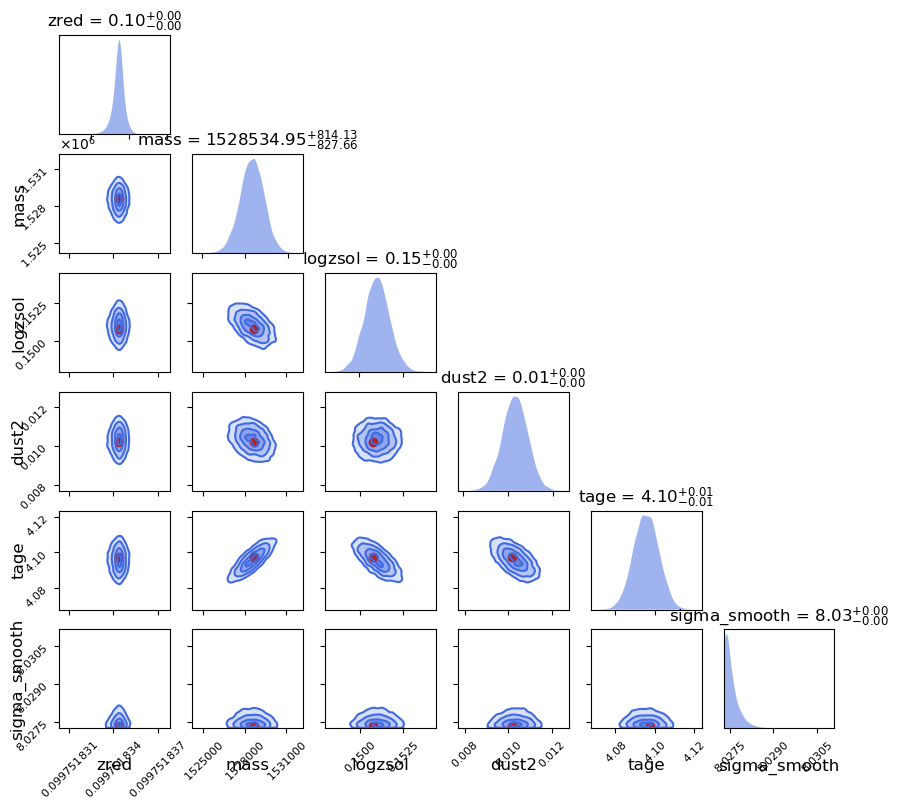

In [111]:
import matplotlib.pyplot as pl
from prospect.plotting import corner
nsamples, ndim = out["chain"].shape
cfig, axes = pl.subplots(ndim, ndim, figsize=(10,9))
axes = corner.allcorner(out["chain"].T, out["theta_labels"], axes, weights=out["weights"], color="royalblue", show_titles=True)

from prospect.plotting.utils import best_sample
pbest = best_sample(out)
corner.scatter(pbest[:, None], axes, color="firebrick", marker="o")

/Users/dagoret/anaconda3/envs/prospector/lib/python3.8/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


KeyError: 'restframe_wavelengths'

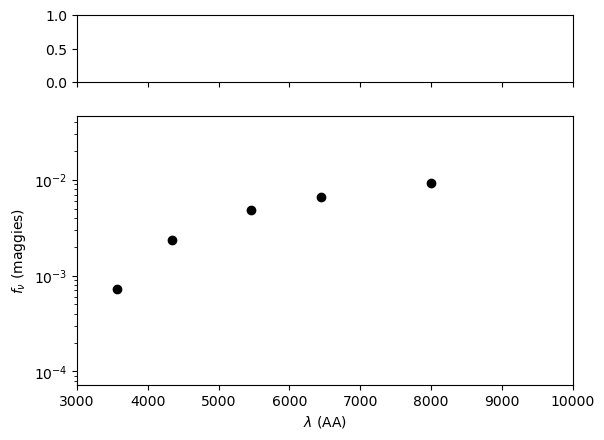

In [112]:
import matplotlib.pyplot as pl
sfig, saxes = pl.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True)
ax = saxes[1]
pwave = np.array([f.wave_effective for f in out_obs["filters"]])
# plot the data
ax.plot(pwave, out_obs["maggies"], linestyle="", marker="o", color="k")
ax.errorbar(pwave,  out_obs["maggies"], out_obs["maggies_unc"], linestyle="", color="k", zorder=10)
ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel(r"$\lambda$ (AA)")
ax.set_xlim(3e3, 1e4)
ax.set_ylim(out_obs["maggies"].min() * 0.1, out_obs["maggies"].max() * 5)
ax.set_yscale("log")

# get the best-fit SED
bsed = out["bestfit"]
ax.plot(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]), bsed["spectrum"], color="firebrick", label="MAP sample")
ax.plot(pwave, bsed["photometry"], linestyle="", marker="s", markersize=10, mec="orange", mew=3, mfc="none")

ax = saxes[0]
chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
ax.plot(pwave, chi, linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylim(-2, 2)
ax.set_ylabel(r"$\chi_{\rm best}$")

In [115]:
bsed.keys()

dict_keys(['parameter', 'photometry', 'spectrum', 'mfrac'])

In [116]:
bsed["spectrum"]

array([0.00057787, 0.00057787, 0.00057787, ..., 0.00731351, 0.00721405,
       0.00713294])

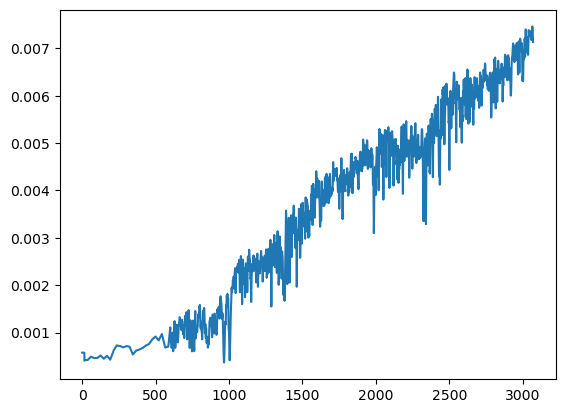

In [119]:
pl.plot(bsed["spectrum"])